In [2]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from scipy.ndimage import generic_filter, gaussian_filter, median_filter
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, remove_small_objects, skeletonize, medial_axis, thin

In [3]:
name = 21
index = 0

image_path = '/Users/zhiweideng/Desktop/NICR/VesselAnalysis/EyeVessel/DRIVE/train/images/{}_training.tif'.format(name)
mask_path = '/Users/zhiweideng/Desktop/NICR/VesselAnalysis/EyeVessel/DRIVE/train/mask/{}_training_mask.gif'.format(name)
label_path = '/Users/zhiweideng/Desktop/NICR/VesselAnalysis/EyeVessel/DRIVE/train/1st_manual/{}_manual1.gif'.format(name)
responses = np.load('/Users/zhiweideng/Desktop/NICR/VesselAnalysis/EyeVessel/DRIVE/visualization/drive_train_naive.npy')
radiis = np.load('/Users/zhiweideng/Desktop/NICR/VesselAnalysis/EyeVessel/DRIVE/visualization/drive_rad_train_naive.npy')

In [4]:
image, mask, label = Image.open(image_path), Image.open(mask_path), Image.open(label_path)
image = -np.asarray(image)[..., 1] / 255.0          # green channel
label = np.asarray(label) / 255.0
mask = np.asarray(mask) > 0.5
rads = radiis[index]

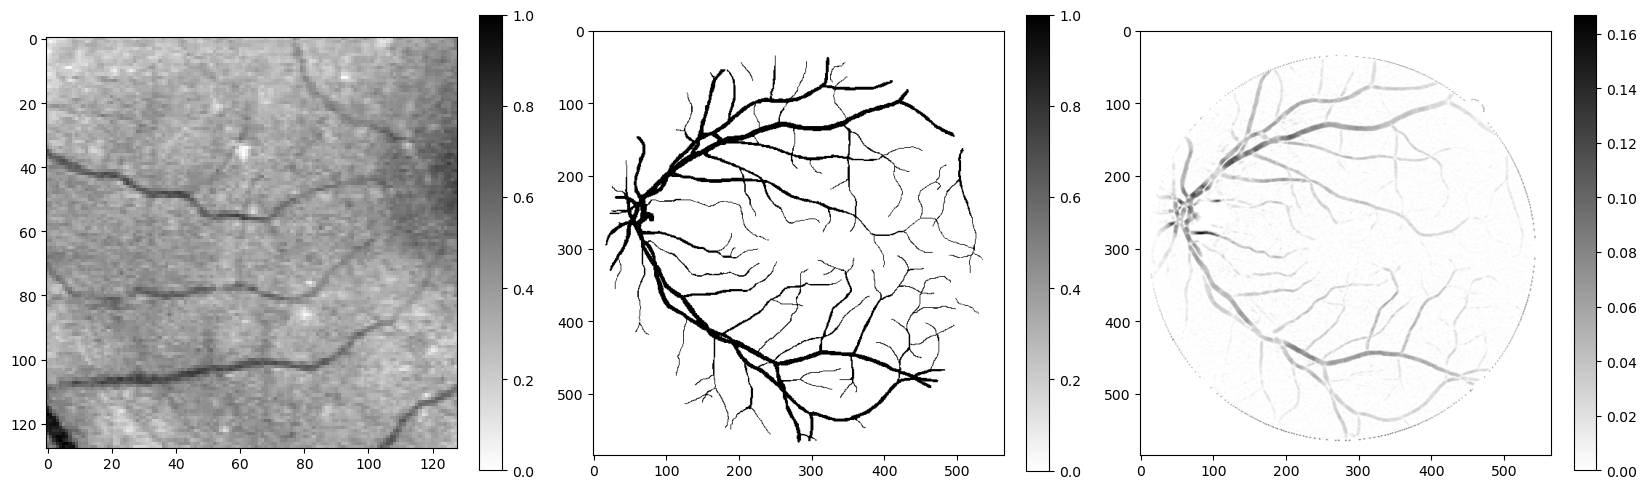

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))
_image = image[256:384, 128:256]
_image = (_image - _image.min()) / (_image.max() - _image.min())
im1 = ax1.imshow(_image, cmap='gray_r')
fig.colorbar(im1, ax=ax1, fraction=0.05)
im2 = ax2.imshow(label, cmap='gray_r')
fig.colorbar(im2, ax=ax2, fraction=0.05)
im3 = ax3.imshow(responses[index], cmap='gray_r')
fig.colorbar(im3, ax=ax3, fraction=0.05)

<Figure size 800x800 with 0 Axes>

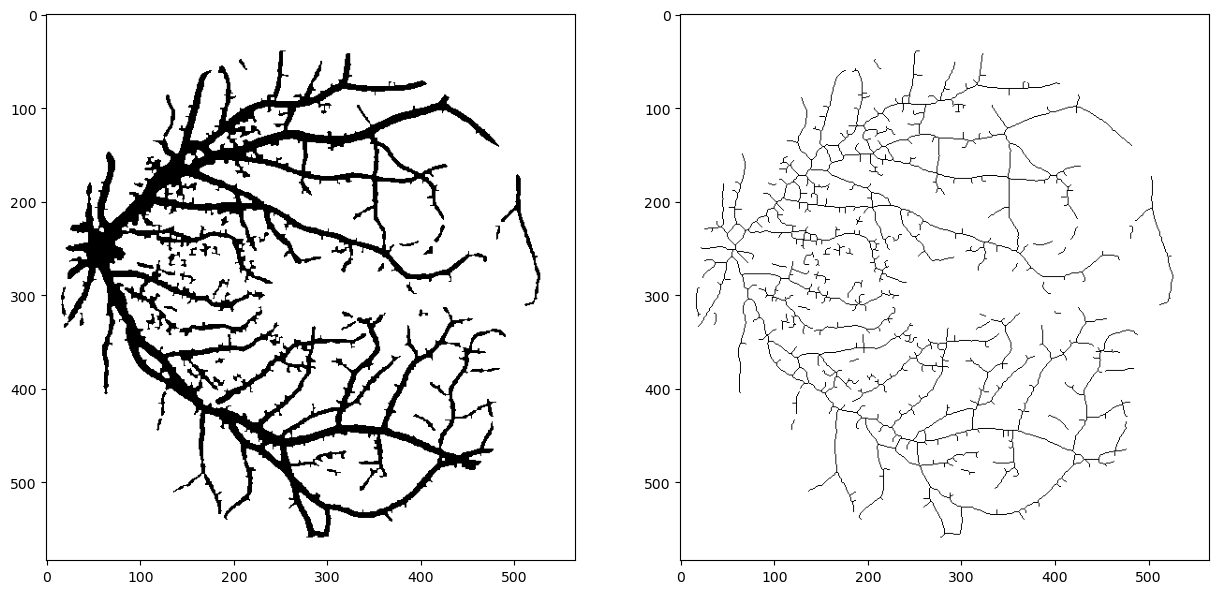

In [25]:
mask_erode = binary_erosion(mask, footprint=np.ones((13, 13)))
response = np.multiply(responses[index], mask_erode)
response = gaussian_filter(response, sigma=0.5)

# binarize the response
threshold = 0.0045
bin_res = binary_closing(response > threshold, footprint=np.ones((3, 3)))
bin_res = remove_small_objects(bin_res, min_size=30)
# bin_res = binary_erosion(bin_res)
skel = skeletonize(bin_res)
fig = plt.figure(figsize=(8, 8))

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(bin_res, cmap='gray_r')
ax2.imshow(skel, cmap='gray_r')

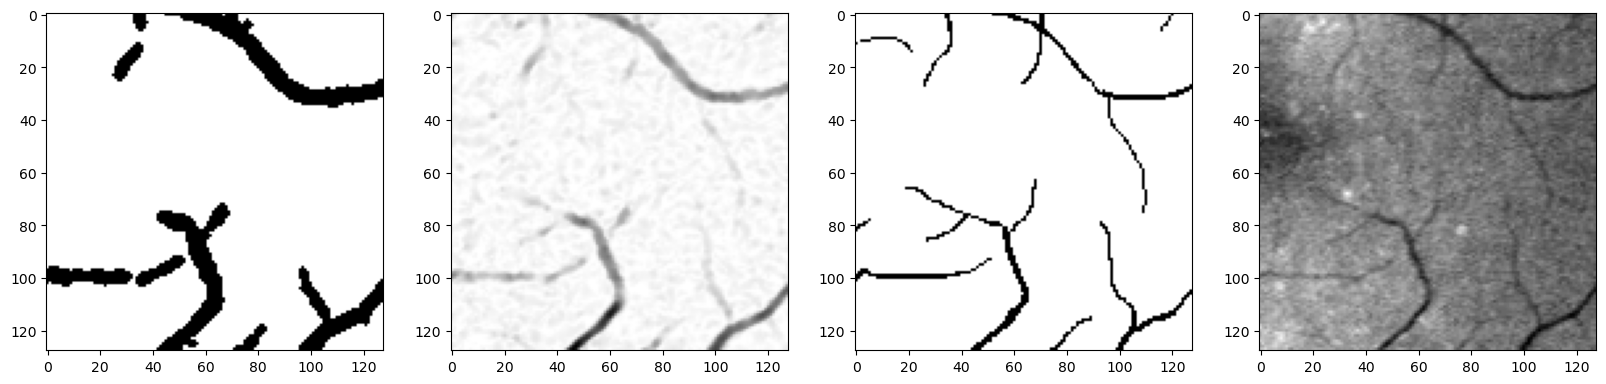

In [14]:
patch_size = 128
x, y = 250, 290

bin_res_patch = bin_res[x:x+patch_size, y:y+patch_size]
flux_patch = response[x:x+patch_size, y:y+patch_size]
label_patch = label[x:x+patch_size, y:y+patch_size]
image_patch = image[x:x+patch_size, y:y+patch_size]
rads_patch = rads[x:x+patch_size, y:y+patch_size]

_, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 20))
ax1.imshow(bin_res_patch, cmap='gray_r')
ax2.imshow(flux_patch, cmap='gray_r')
ax3.imshow(label_patch, cmap='gray_r')
ax4.imshow(image_patch, cmap='gray_r')

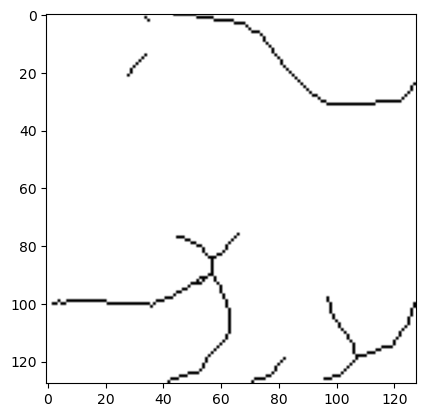

In [15]:
skel_patch = skeletonize(binary_dilation(bin_res_patch)) > 0.5
plt.imshow(skel_patch, cmap='gray_r')

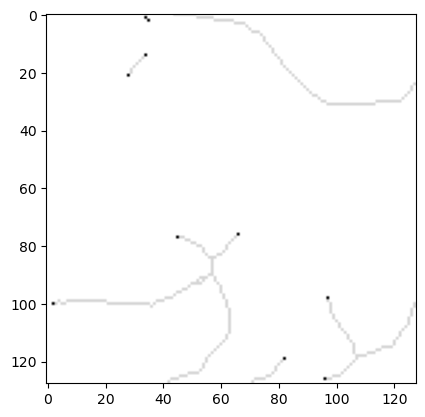

In [16]:
def line_ends(patch):
    return patch[4] == 1 and np.sum(patch) == 2

line_ends_im = generic_filter(skel_patch, line_ends, (3, 3))
locations = np.argwhere(line_ends_im > 0.5)
plt.imshow(line_ends_im * 5 + skel_patch, cmap='gray_r')

# Start Sampling the Curves

In [179]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from loss import get_sampling_vec

In [180]:
_flux_patch = torch.from_numpy(flux_patch).unsqueeze(0).unsqueeze(0)
_locations = torch.from_numpy(locations).unsqueeze(0)
_optimal_dir = F.normalize(torch.randn(locations.shape[0], 2).unsqueeze(0), dim=-1)
_estimated_rad = torch.ones(locations.shape[0], 128).unsqueeze(0) * 0.5
# line_ends_rads = rads_patch[locations[:, 0], locations[:, 1]]
# _estimated_rad = torch.from_numpy(line_ends_rads).repeat(128, 1).unsqueeze(0)
# _estimated_rad = _estimated_rad.permute(0, 2, 1) * 0.6
print(_estimated_rad.shape)

samplings = get_sampling_vec(32, dim=4)
print(samplings.shape)

torch.Size([1, 32, 128])
torch.Size([32, 2])


In [181]:
def construct_P(step_len, k1, k2=None):
    """
    generate propagation matrix
    :param step_len: sample length for single step, float
    :param k1: first curvature for line-end points, 2D: [b, n]; 3D: [b, n]
    :param k2: second curvature for line-end points, 3D: [b, n]
    :return: P, propagation matrix, 2D: [b, n, 3, 3]; 3D: [b, n, 4, 4]
    """
    k1 = k1.clone() + torch.ones_like(k1) * 1e-20
    # 2d case
    if k2 is None:
        b, n = k1.size()
        skt = torch.sin(k1 * step_len)
        ckt = torch.cos(k1 * step_len)
        # construct the propagation matrix
        P = torch.zeros(b, n, 3, 3)
        P[:, :, 0, 0] = torch.ones(b, n)
        P[:, :, 0, 1] = torch.div(skt, k1)
        P[:, :, 0, 2] = torch.div(1.0 - ckt, k1)
        P[:, :, 1, 1] = ckt
        P[:, :, 1, 2] = skt
        P[:, :, 2, 1] = -skt
        P[:, :, 2, 2] = ckt
    # 3d case
    else:
        b, n = k1.size()
        k2 = k2.clone() + torch.ones_like(k2) * 1e-20
        k = torch.sqrt(k1 ** 2 + k2 ** 2)
        skt = torch.sin(torch.mul(k, step_len))
        ckt = torch.cos(torch.mul(k, step_len))
        # construct the propagation matrix
        P = torch.zeros(b, n, 4, 4)
        P[:, :, 0, 0] = torch.ones(b, n)
        P[:, :, 0, 1] = torch.div(skt, k)
        P[:, :, 0, 2] = torch.div(torch.mul(k1, (1.0 - ckt)), k ** 2)
        P[:, :, 0, 3] = torch.div(torch.mul(k2, (1.0 - ckt)), k ** 2)
        P[:, :, 1, 1] = ckt
        P[:, :, 1, 2] = torch.div(torch.mul(k1, skt), k)
        P[:, :, 1, 3] = torch.div(torch.mul(k2, skt), k)
        P[:, :, 2, 1] = torch.div(-torch.mul(k1, skt), k)
        P[:, :, 2, 2] = torch.div(k2 ** 2 + torch.mul(k1 ** 2, ckt), k ** 2)
        P[:, :, 2, 3] = torch.div(torch.mul(torch.mul(k1, k2), (ckt - 1.0)), k ** 2)
        P[:, :, 3, 1] = torch.div(-torch.mul(k2, skt), k)
        P[:, :, 3, 2] = torch.div(torch.mul(torch.mul(k1, k2), (ckt - 1.0)), k ** 2)
        P[:, :, 3, 3] = torch.div(k1 ** 2 + torch.mul(k2 ** 2, ckt), k ** 2)
    return P


def propagate_frame(frame, step_len, k1, k2=None):
    """
    generate next frame based on current frame and curvature
    :param frame: current parallel transport frame, shape of [b, n, 3, 2], 3D: [b, n, 4, 3]
    :param step_len: sample length for single step, float
    :param k1: first curvature learnt from the network, 2D: [b, n]; 3D: [b, n]
    :param k2: second curvature learnt from the network, 3D: [b, n]
    :return: next frame, shape of [b, n, 3, 2], 3D: [b, n, 4, 3]
    """
    # get the P matrix
    P = construct_P(step_len, k1, k2).to(frame.device)
    # reshape the matrix, 2d case
    original_size = frame.size()
    if k2 is None:
        P = P.view(-1, 3, 3)
        frame = frame.view(-1, 3, 2)
    # reshape the matrix, 3d case
    else:
        P = P.view(-1, 4, 4)
        frame = frame.view(-1, 4, 3)
    next_frame = torch.bmm(P, frame)
    # recover the frame shape
    next_frame = next_frame.view(original_size)
    return next_frame

In [182]:
def get_rotation_matrix_3d(src_dir, des_dir):
    """
    Compute a matrix R that rotates v1 to align with v2
    :param src_dir: 3D image [B, N, 3]. Optimal direction
    :param des_dir: 3-dim 1d vector
    :return: rotation_matrices, 3 by 3 rotation matrix
    """
    b, n, c = src_dir.size()                                                # dimension of the vector
    src_dir = F.normalize(src_dir, dim=-1).view(-1, c)                      # normalize the vectors and flatten pixels
    des_dir = F.normalize(des_dir, dim=0)                                   # normalize the destination vectors
    des_dir = des_dir.repeat((src_dir.size(0), 1))                          # destination shape [N(b*k), 3]
    t = torch.bmm(src_dir.unsqueeze(2), des_dir.unsqueeze(1))               # [N, 3, 3]
    t -= torch.bmm(des_dir.unsqueeze(2), src_dir.unsqueeze(1))              # [N, 3, 3]
    rotation_matrices = torch.eye(c).repeat((src_dir.size(0), 1, 1))        # initialize the rotation matrix
    angle = torch.sum(src_dir * des_dir, dim=1)[:, None, None]              # the angle between the vectors [B,]
    rotation_matrices += t + torch.bmm(t, t) / (1 + angle)                  # construct the reconstruction matrix
    pos_indices = torch.argwhere(torch.abs(angle - 1.0) < 1.0e-10)          # find edge cases, same direction
    neg_indices = torch.argwhere(torch.abs(angle + 1.0) < 1.0e-10)          # find edge cases, opposite direction
    rotation_matrices[pos_indices] = torch.eye(c)                           # same direction,  identity
    rotation_matrices[neg_indices] = -torch.eye(c)                          # opposite direction, reverse identity
    rotation_matrices = rotation_matrices.view(b, n, c, c)                  # re-assemble the pixels
    return rotation_matrices

def get_local_frame(optimal_dir):
    """
    Compute the local frame based on the optimal dir
    :param optimal_dir: Optimal direction, 2D image [B, N, 2], 3D image [B, N, 3]
    :return: local frames, 2D image [B, N, 2, 2], 3D image [B, N, 3, 3]
    """
    if optimal_dir.shape[-1] == 3:
        x_axis = torch.tensor([1, 0, 0]) + 0.0
        y_axis = torch.tensor([0, 1, 0]) + 0.0
        z_axis = torch.tensor([0, 0, 1]) + 0.0
        rt_mtx = get_rotation_matrix_3d(optimal_dir, z_axis)
        new_x_axis = torch.matmul(rt_mtx, x_axis)
        new_y_axis = torch.matmul(rt_mtx, y_axis)
        frame = torch.stack((new_x_axis, new_y_axis, optimal_dir), dim=-1)
    else:
        index = torch.LongTensor([1, 0]).to(optimal_dir.device)
        ort_dir1 = torch.index_select(optimal_dir, -1, index)               # [B, N, 2]
        ort_dir1[:, :, 1] = - ort_dir1[:, :, 1]                             # [B, N, 2]
        ort_dir1 = F.normalize(ort_dir1, dim=-1) + 1e-10                    # [B, K, 2]
        frame = torch.stack((optimal_dir, ort_dir1), dim=3)                 # [B, N, 2, 2]
    return frame

def model_tube(flux, init_frame, mean_rad, probe_num, sample_pt_num, step_len, k1, k2=None):
    """
    Model the tube structure of the vessel
    :param flux: 2D image [B, 1, H, W], 3D image [B, 1, H, W, D]. Vesselness response
    :param init_frame: initial image frame, [B, N, 3, 2], [B, N, 4, 3], in image space
    :param mean_rad: scalar field of mean radius, [B, H, W, 1], [B, H, W, D, 1]
    :param probe_num: number of probing
    :param sample_pt_num: number of sampling on the cross-sectional plane
    :param step_len: step length of each probe, in pixels
    :param k1: first curvature, [B, N, 1], [B, N, 1]
    :param k2: second curvature, [B, N，1]
    :return: response_prior
    """
    device = flux.device
    b, c, h, w = flux.shape[:4]
    n = k1.shape[1]
    k1 = k1.squeeze(-1)                                                     # [B, N], [B, N]
    k2 = k2.squeeze(-1) if k2 is not None else None                         # [B, N]
    step_len = step_len if isinstance(step_len, float) else step_len.squeeze(-1)
    indices = torch.LongTensor([2, 1, 0]) if init_frame.shape[-1] == 3 else torch.LongTensor([1, 0])
    indices = indices.to(device)
    response_prior = torch.zeros((b, c, 1, n), device=device)               # initialize the accumulated vesselness
    curr_frame = init_frame                                                 # initial image frame, normalized
    final_path = []
    for _ in range(probe_num):
        xt = torch.select(curr_frame, dim=-2, index=0)                      # image coordinates in image space
        Tt = torch.select(curr_frame, dim=-2, index=1)                      # normalized vessel direction
        K1 = torch.select(curr_frame, dim=-2, index=2)                      # normalized k1 direction
        K2 = torch.select(curr_frame, dim=-2, index=3) if curr_frame.dim() == 6 else None
        final_path.append(xt)
        for i in torch.linspace(-1.0, 1.0, sample_pt_num):
            sample_pt_num_2 = sample_pt_num if K2 is not None else 1
            for j in torch.linspace(-1.0, 1.0, sample_pt_num_2):
                if K2 is not None:
                    sample_dir = F.normalize(K1 * i + K2 * j, dim=-1)       # [B, N, 2], [B, N, 3]
                else:
                    sample_dir = F.normalize(K1 * i, dim=-1)                # [B, N, 2], [B, N, 3]
                sample_pos = xt + sample_dir * mean_rad                     # sample position over the image
                sample_pos = torch.index_select(sample_pos, -1, indices)    # swap the x and z axis
                sample_pos[..., 0] = 2.0 * sample_pos[..., 0] / h - 1
                sample_pos[..., 1] = 2.0 * sample_pos[..., 1] / w - 1
                sample_pos = sample_pos.unsqueeze(dim=1).double()
                curr_response = F.grid_sample(flux, sample_pos, align_corners=True)
                response_prior += curr_response / sample_pt_num / sample_pt_num_2 / probe_num
        curr_frame = propagate_frame(curr_frame, step_len, k1, k2)          # propagate the image frame
    response_prior = response_prior.view(b, -1)
    final_path = torch.stack(final_path, dim=-2)
    return response_prior, final_path

In [183]:
def sample_curve(flux_res, optimal_dir, estimated_rad, end_locs, sample_num, prob_num=10, pt_num=5, step_len=0.5):
    """
    Sample the curves over the whole images
    :param flux_res: 2D image [B, 1, H, W], 3D image [B, 1, H, W, D]. Vesselness response
    :param optimal_dir: 2D image [B, K, 2], 3D image [B, K, 3]. Optimal direction
    :param estimated_rad: 2D image [B, H, W, R], 3D image [B, H, W, D, R]. Estimated radius
    :param end_locs: line-ends locations, [B, N, 2], [B, N, 3]
    :param sample_num: number of curves to probe
    :param prob_num: number of probing of vessels
    :param pt_num: number of sampling on the cross-sectional plane
    :param step_len: step length of each probe, in pixels
    :return:
    """
    b, n, ndim = end_locs.shape
    device, dim = flux_res.device, flux_res.dim()                           # dimension of response, 2d or 3d
    mean_rad = torch.mean(estimated_rad, dim=-1, keepdim=True)              # mean radius, [B, H, W, 1], [B, H, W, D, 1]
    min_rad, _ = torch.min(estimated_rad, dim=-1, keepdim=True)             # min radius, [B, H, W, 1], [B, H, W, D, 1]
    # print(min_rad.size())
    optimal_prior = torch.zeros((b, n), device=device)                      # [B, H, W, 1], [B, H, W, D, 1]
    optimal_k1 = torch.zeros((b, n), device=device)                # [B, H, W, 1], [B, H, W, D, 1]
    optimal_k2 = torch.zeros((b, n), device=device) if dim == 5 else None      # [B, H, W, D, 1]
    # repeat_size = (1, 1, 1, 1, 6 * prob_num) if dim == 5 else (1, 1, 1, 4 * prob_num)
    optimal_path = torch.zeros((b, n, 2, prob_num, ndim), device=device)     # [B, H, W, prob_num * 2]
    ranges = torch.linspace(-0.035, 0.035, sample_num)
    for j in tqdm(range(samplings.shape[0])):
        optimal_dir = samplings[j].repeat((b, n, 1))
        frame = get_local_frame(optimal_dir)                                    # local frame of every
        init_frame = torch.cat((end_locs.unsqueeze(-2), frame), dim=-2)         # [B, K, 3, 2], [B, K, 4, 3]
        init_frame_r = torch.cat((end_locs.unsqueeze(-2), -frame), dim=-2)      # reversed frame
        
        for i in range(sample_num):
            k1 = torch.ones(mean_rad.size(), device=device) * ranges[i] / mean_rad / 2.0
            k2 = torch.ones(mean_rad.size(), device=device) * ranges[i] / mean_rad / 2.0 if dim == 5 else None
            # model the tube and calculate prior
            prior_1, final_path_1 = model_tube(flux_res, init_frame, mean_rad, prob_num, pt_num, min_rad * step_len, k1, k2)
            prior_2, final_path_2 = model_tube(flux_res, init_frame_r, mean_rad, prob_num, pt_num, min_rad * step_len, -k1, k2)
            response_prior = prior_1 + prior_2
            # update the optimal curvatures based on the priors
            optimal_k1 = torch.where(response_prior > optimal_prior, k1, optimal_k1)
            if k2 is not None:
                optimal_k2 = torch.where(response_prior > optimal_prior, k2, optimal_k2)
            # update the optimal path
            # temp_prior, temp_optimal_prior = response_prior.repeat(repeat_size), optimal_prior.repeat(repeat_size)
            final_path = torch.stack((final_path_1, final_path_2), dim=-3)
            threshes = torch.ones_like(optimal_prior) * 0.009
            optimal_indices = torch.where(response_prior > torch.maximum(optimal_prior, threshes))
            optimal_indices = torch.stack(optimal_indices, dim=-1)
            if len(optimal_indices) > 0:
                # update the optimal path
                optimal_path[optimal_indices[:, 0], optimal_indices[:, 1]] = final_path[optimal_indices[:, 0], optimal_indices[:, 1]]
                # update the optimal priors
                optimal_prior[optimal_indices[:, 0], optimal_indices[:, 1]] = response_prior[optimal_indices[:, 0], optimal_indices[:, 1]]
    optimal_res = {
        'prior': optimal_prior,
        'k1': optimal_k1,
        'k2': optimal_k2,
        'path': optimal_path
    }
    return optimal_res

res = sample_curve(_flux_patch, _optimal_dir, _estimated_rad, _locations, sample_num=32, prob_num=40)    
print(res['path'].shape)

100%|██████████| 32/32 [00:24<00:00,  1.29it/s]

torch.Size([1, 32, 2, 40, 2])


tensor(0.0238)


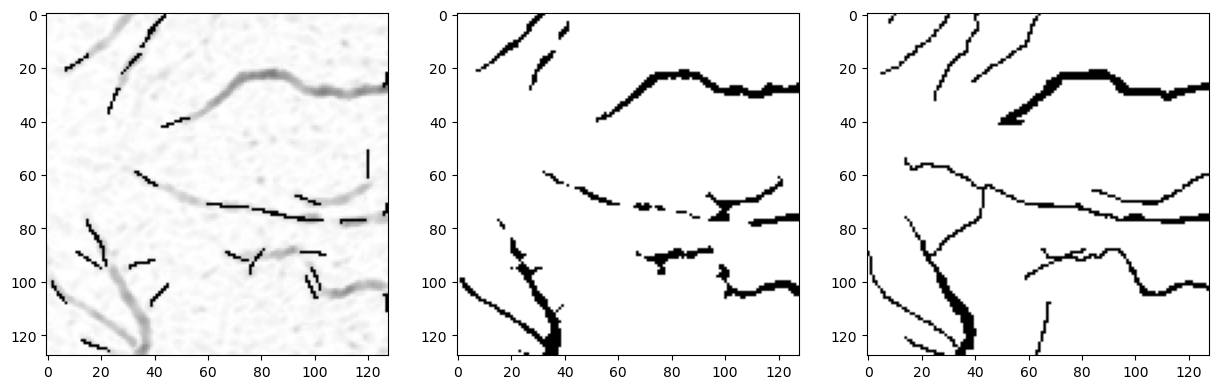

In [187]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))

# new_bin_res_patch = bin_res_patch.copy()
new_bin_res_patch = flux_patch

for i in range(res['path'].shape[1]):
    curr_path1 = res['path'][0, i, 0]
    curr_path2 = res['path'][0, i, 1]
    curr_path1 = np.minimum(curr_path1, 127.0)
    curr_path2 = np.minimum(curr_path2, 127.0)
    # ax1.plot(curr_path1[:, 1], curr_path1[:, 0], color='red', linewidth=1.0)
    new_bin_res_patch[curr_path1[:, 0].int(), curr_path1[:, 1].int()] = 0.1
    # new_bin_res_patch[curr_path2[:, 0].int(), curr_path2[:, 1].int()] = 1.0
    # plt.plot(curr_path2[:, 1], curr_path2[:, 0], color='black')
    
ax1.imshow(new_bin_res_patch, cmap='gray_r')
ax2.imshow(bin_res_patch, cmap='gray_r')
ax3.imshow(label_patch, cmap='gray_r')
print(res['prior'].mean())

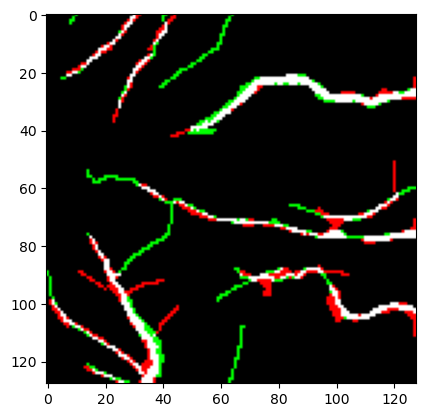

In [185]:
def get_image_difference(v_threshed, lab):
    # Get difference
    h, w = v_threshed.shape
    diff = np.zeros((h, w, 3))
    # Color tp pixels white
    tp = (v_threshed == 1) & (lab == 1)
    y, x = np.where(tp)
    diff[y, x, :] = 1.0
    # Color fp pixels red
    fp = (v_threshed == 1) & (lab == 0)
    y, x = np.where(fp)
    diff[y, x, 0] = 1.0
    # Color fn pixels green
    fn = (v_threshed == 0) & (lab == 1)
    y, x = np.where(fn)
    diff[y, x, 1] = 1.0
    diff = (diff * 255).astype(np.uint8)
    # Get image
    im = Image.fromarray(diff)
    return im

diff = get_image_difference(binary_closing(new_bin_res_patch), label_patch)
plt.imshow(diff, cmap='gray')

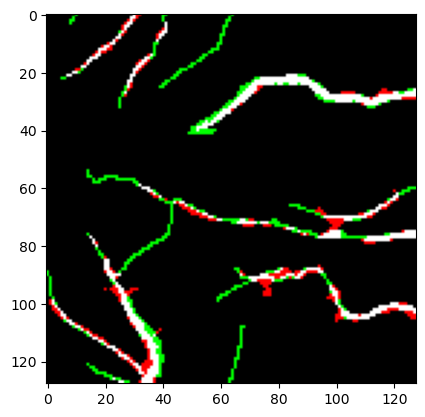

In [186]:
diff = get_image_difference(bin_res_patch, label_patch)
plt.imshow(diff)

In [382]:
def accuracy(v_threshed, gt):
    return np.array(v_threshed == gt).astype(float).mean()

print(accuracy(bin_res_patch, label_patch))
print(accuracy(binary_closing(new_bin_res_patch), label_patch))

0.9340529336734694
0.9315784438775511


In [383]:
from skimage.morphology import skeletonize, skeletonize_3d

def cl_score(v, s):
    """[this function computes the skeleton volume overlap]

    Args:
        v ([bool]): [image]
        s ([bool]): [skeleton]

    Returns:
        [float]: [computed skeleton volume intersection]
    """
    return np.sum(v*s)/np.sum(s)


def clDice(v_p, v_l):
    """[this function computes the cldice metric]

    Args:
        v_p ([bool]): [predicted image]
        v_l ([bool]): [ground truth image]

    Returns:
        [float]: [cldice metric]
    """
    if len(v_p.shape) == 2:
        tprec = cl_score(v_p, skeletonize(v_l))
        tsens = cl_score(v_l, skeletonize(v_p))
    else:
        tprec = cl_score(v_p, skeletonize_3d(v_l))
        tsens = cl_score(v_l, skeletonize_3d(v_p))
    return 2 * tprec * tsens / (tprec+tsens)

In [384]:
print(clDice(bin_res_patch, label_patch))
print(clDice(binary_closing(new_bin_res_patch), label_patch))

0.7544137921614785
0.7362737871216745


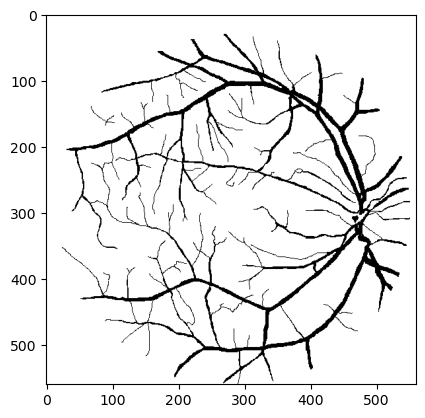

In [321]:
plt.imshow(label_patch, cmap='gray_r')

In [14]:
from torchvision.transforms.functional import crop


img = torch.randn(1, 128, 128, 128)
cropped = crop(img, 12, 12, 64, 64)
cropped.shape

torch.Size([1, 128, 64, 64])

In [16]:
import time

start = time.time()
features = torch.randn(4, 1, 128, 128)
indices = torch.randn(4, 1, 30, 2)
s = F.grid_sample(features, indices, align_corners=True)
end = time.time()
end-start

0.0011179447174072266

In [20]:
start = time.time()
features = torch.randn(160, 1, 32, 32)
indices = torch.randn(160, 1, 1, 2)
s = F.grid_sample(features, indices, align_corners=True)
end = time.time()
end-start

0.0018203258514404297

In [321]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.filters import gaussian

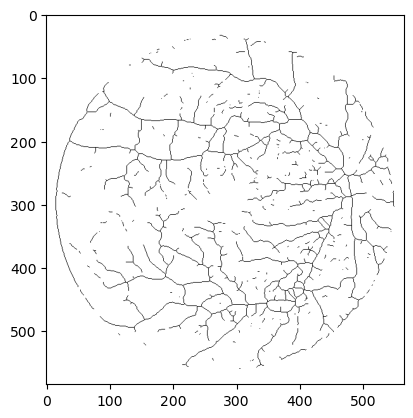

In [322]:
fixed = np.load('/Users/zhiweideng/Desktop/NICR/VesselAnalysis/visualization/flux_22_training.npy')
fixed = gaussian(fixed, sigma=0.8)
bin_fixed = binary_closing(fixed > 0.011)
bin_fixed = remove_small_objects(bin_fixed, min_size=15)
bin_fixed = binary_erosion(bin_fixed)
bin_skel = skeletonize(bin_fixed)
plt.imshow(bin_skel, cmap='gray_r')

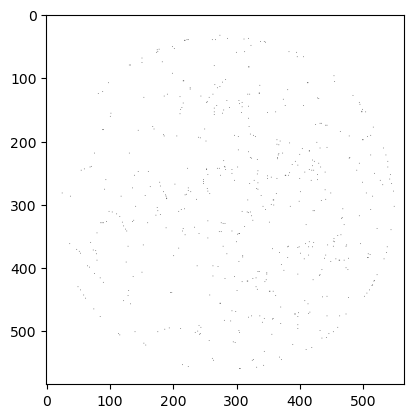

In [323]:
def line_ends(patch):
    return patch[4] == 1 and np.sum(patch) == 2


line_ends_im = generic_filter(bin_skel, line_ends, (3, 3))
locations = np.argwhere(line_ends_im == 1.0)
plt.imshow(line_ends_im, cmap='gray_r')

(384, 2)


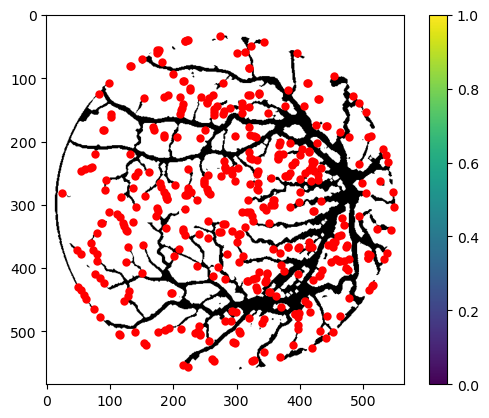

In [324]:
rads = np.load('/Users/zhiweideng/Desktop/NICR/VesselAnalysis/visualization/rads_22_training.npy') 
mean_rads = np.mean(rads, axis=0)
valid_line_ends = ((mean_rads * line_ends_im) < 2.8) * ((mean_rads * line_ends_im) > 0.001)
locs = np.argwhere(valid_line_ends > 0.5)
print(locs.shape)
plt.imshow(bin_fixed, cmap='gray_r')
plt.scatter(locs[:, 1], locs[:, 0], color='red', linewidths=0.01)
plt.colorbar()

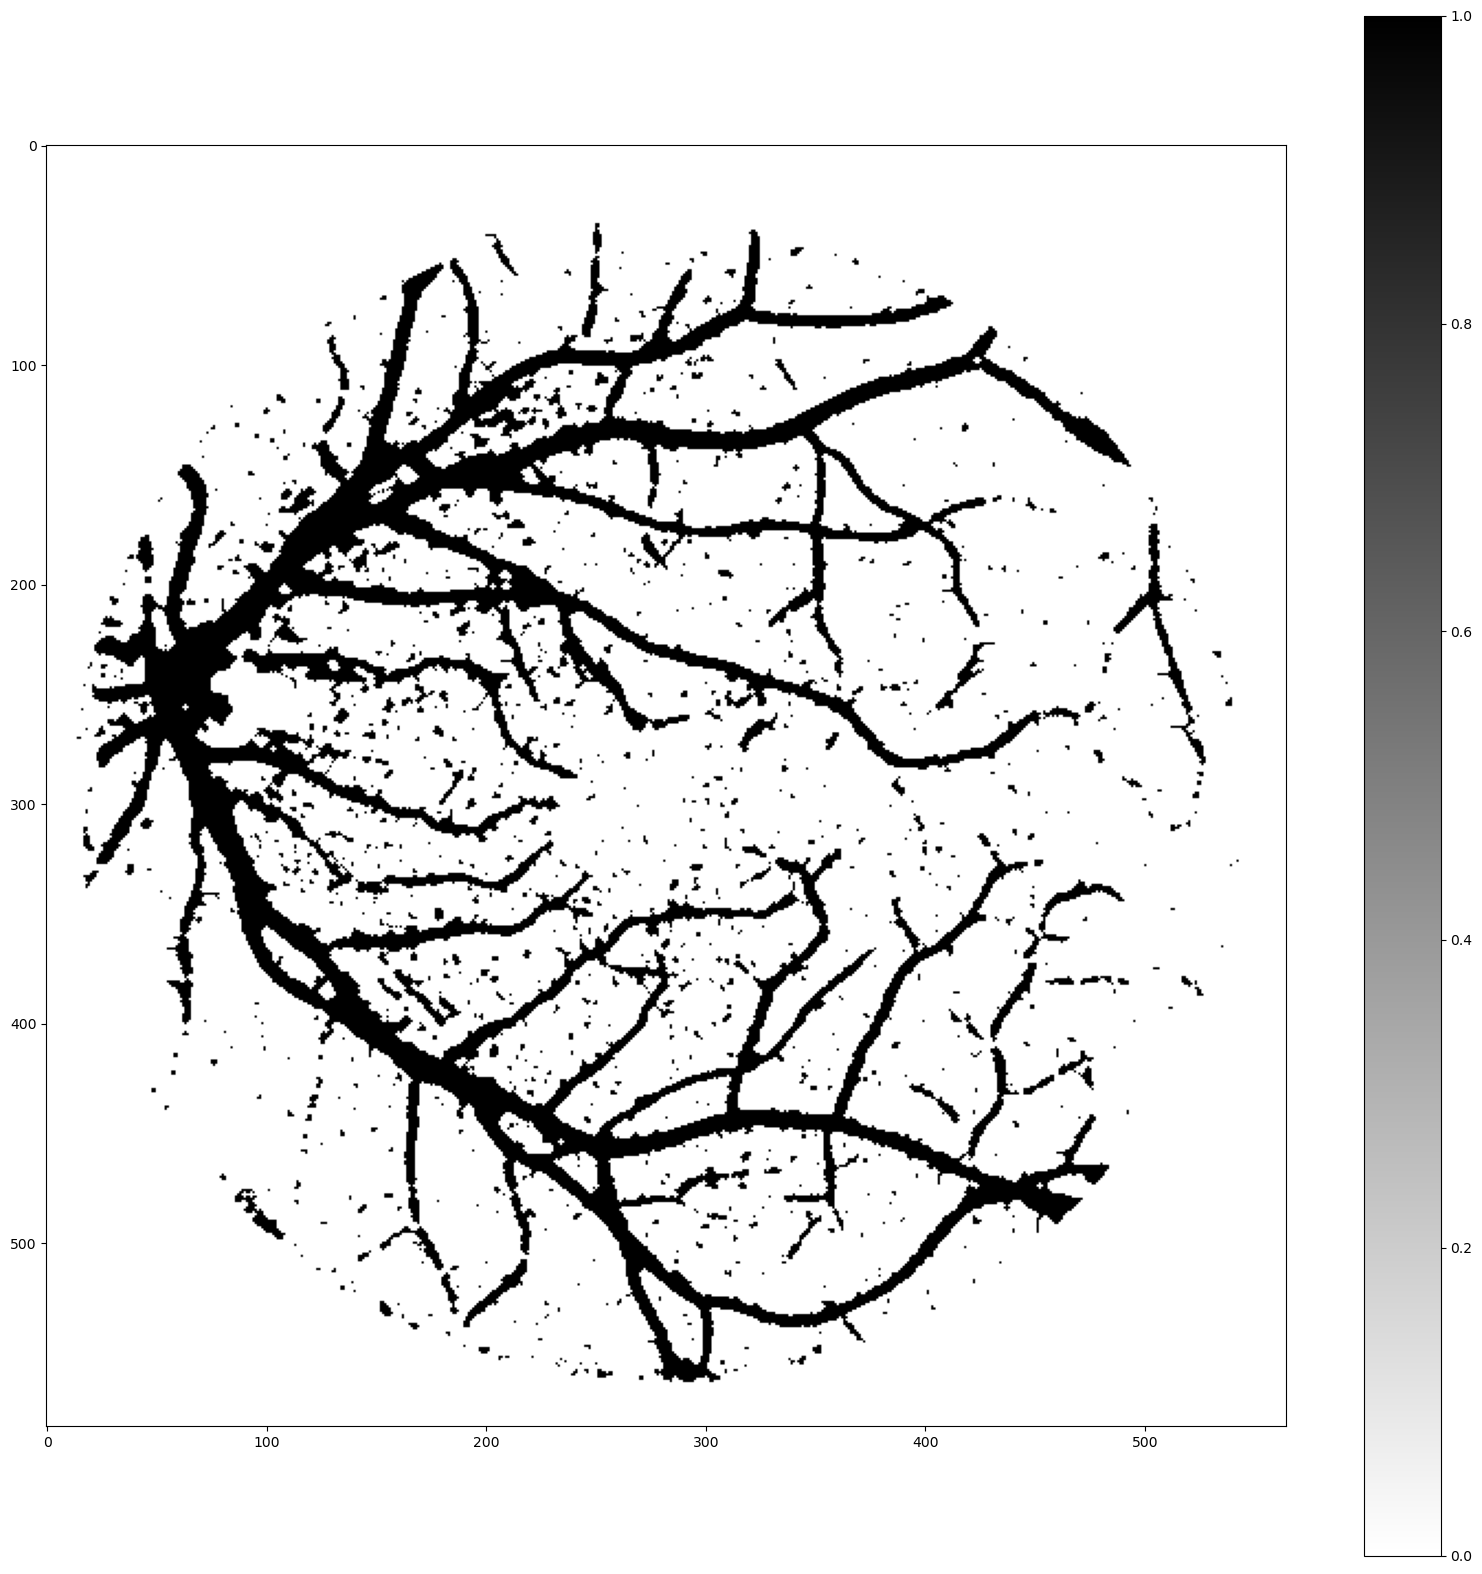

In [370]:
fixed = np.load('/Users/zhiweideng/Desktop/NICR/VesselAnalysis/visualization/fixed_flux_21_training.npy')
flux = np.load('/Users/zhiweideng/Desktop/NICR/VesselAnalysis/visualization/flux_21_training.npy')

# fixed = gaussian(fixed[0], sigma=0.3)
bin_res = binary_closing(fixed[0] > 0.012)
bin_res = remove_small_objects(bin_res, min_size=1)
# bin_res = binary_erosion(bin_res)
fig = plt.figure(figsize=(20, 20))
plt.imshow(bin_res, cmap='gray_r')
plt.colorbar()

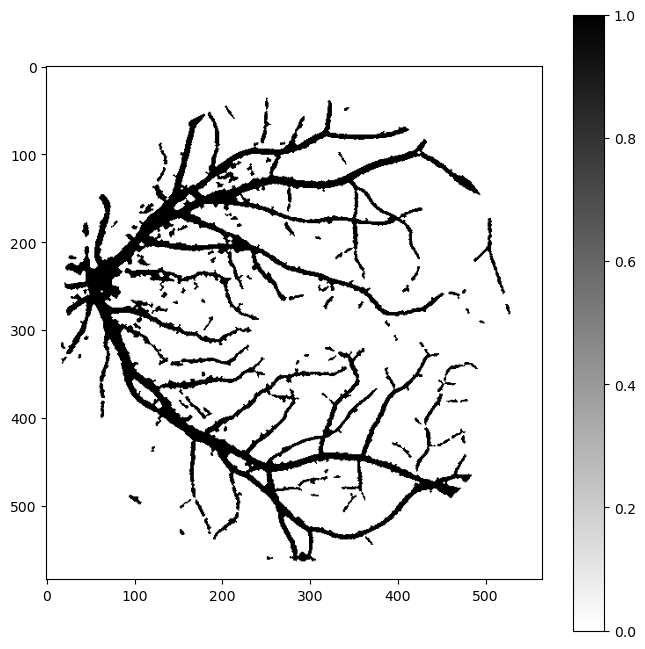

In [351]:
bin_res = binary_closing(flux > 0.012)
bin_res = remove_small_objects(bin_res, min_size=15)
# bin_res = binary_erosion(bin_res)
fig1 = plt.figure(figsize=(8, 8))
plt.imshow(bin_res, cmap='gray_r')
plt.colorbar()